In [1]:
!python -V

Python 3.9.7


In [25]:
%pip install --upgrade mlflow

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd

In [2]:
import pickle

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
import mlflow
mlflow.set_tracking_uri("sqlite:////Users/pravin/mlflow.db")
mlflow.set_experiment("new_experiment2")

2024/06/02 13:51:00 INFO mlflow.tracking.fluent: Experiment with name 'new_experiment2' does not exist. Creating a new experiment.


<Experiment: artifact_location='/Users/pravin/Zoomcamp-1/02-mlops/mlruns/3', creation_time=1717332660389, experiment_id='3', last_update_time=1717332660389, lifecycle_stage='active', name='new_experiment2', tags={}>

In [6]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [7]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [8]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.838799799829445

/var/folders/3h/9whll2jd5h72wfw3vyg9bmmh0000gp/T/ipykernel_41403/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/var/folders/3h/9whll2jd5h72wfw3vyg9bmmh0000gp/T/ipykernel_41403/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, lab

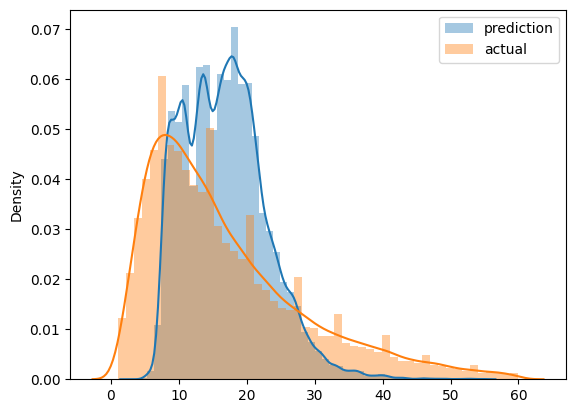

In [9]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [10]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [11]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [12]:
len(df_train), len(df_val)

(73908, 61921)

In [13]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [14]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [15]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.758715208946364

In [17]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [23]:
with mlflow.start_run():

    mlflow.set_tag("developer","poov")

    mlflow.log_param("train_data_path","https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet")
    mlflow.log_param("val_data_path","https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet")

    alpha=0.0001
    mlflow.log_param("alpha",alpha)
    la = Lasso(alpha)
    la.fit(X_train, y_train)

    y_pred = la.predict(X_val)

    meansqe_error=mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse",meansqe_error)

/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [24]:
import xgboost as xgb

In [25]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [26]:
train =xgb.DMatrix(X_train, label=y_train)
valid=xgb.DMatrix(X_val,label=y_val)

In [33]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [34]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=5,
    trials=Trials()
)

  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:31:11] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.95592                          
[1]	validation-rmse:6.72570                          
[2]	validation-rmse:6.68830                          
[3]	validation-rmse:6.67315                          
[4]	validation-rmse:6.66340                          
[5]	validation-rmse:6.65662                          
[6]	validation-rmse:6.65527                          
[7]	validation-rmse:6.65089                          
[8]	validation-rmse:6.63597                          
[9]	validation-rmse:6.62586                          
[10]	validation-rmse:6.62059                         
[11]	validation-rmse:6.61813                         
[12]	validation-rmse:6.61571                         
[13]	validation-rmse:6.61633                         
[14]	validation-rmse:6.61199                         
[15]	validation-rmse:6.60870                         
[16]	validation-rmse:6.60624                         
[17]	validation-rmse:6.60311                         
[18]	validation-rmse:6.60163

2024/06/05 10:31:27 ERROR mlflow.xgboost: Failed to log feature importance plot. XGBoost autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/mlflow/xgboost/__init__.py", line 674, in train_impl
    log_feature_importance_plot(features, importance, imp_type)
  File "/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/mlflow/xgboost/__init__.py", line 567, in log_feature_importance_plot
    fig.tight_layout()
  File "/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/matplotlib/figure.py", line 3538, in tight_layout
    engine.execute(self)
  File "/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/matplotlib/layout_engine.py", line 181, in execute
    renderer = fig._get_renderer()
  File "/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/matplotlib/figure.py", line 2755, in _get_renderer
    return self.canvas.get_renderer()
  File "/

 20%|██        | 1/5 [00:20<01:21, 20.44s/trial, best loss: 6.629004210040684]

/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:31:31] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.54162                                                   
[1]	validation-rmse:6.83639                                                   
[2]	validation-rmse:6.69706                                                   
[3]	validation-rmse:6.65079                                                   
[4]	validation-rmse:6.63524                                                   
[5]	validation-rmse:6.63014                                                   
[6]	validation-rmse:6.62146                                                   
[7]	validation-rmse:6.61579                                                   
[8]	validation-rmse:6.61333                                                   
[9]	validation-rmse:6.60944                                                   
[10]	validation-rmse:6.60365                                                  
[11]	validation-rmse:6.60235                                                  
[12]	validation-rmse:6.59794                        

2024/06/05 10:31:47 ERROR mlflow.xgboost: Failed to log feature importance plot. XGBoost autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/mlflow/xgboost/__init__.py", line 674, in train_impl
    log_feature_importance_plot(features, importance, imp_type)
  File "/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/mlflow/xgboost/__init__.py", line 567, in log_feature_importance_plot
    fig.tight_layout()
  File "/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/matplotlib/figure.py", line 3538, in tight_layout
    engine.execute(self)
  File "/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/matplotlib/layout_engine.py", line 181, in execute
    renderer = fig._get_renderer()
  File "/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/matplotlib/figure.py", line 2755, in _get_renderer
    return self.canvas.get_renderer()
  File "/

 40%|████      | 2/5 [00:39<00:59, 19.88s/trial, best loss: 6.558768203453792]

/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:31:51] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.68359                                                  
[1]	validation-rmse:11.19823                                                  
[2]	validation-rmse:10.75398                                                  
[3]	validation-rmse:10.34847                                                  
[4]	validation-rmse:9.97806                                                   
[5]	validation-rmse:9.64084                                                   
[6]	validation-rmse:9.33433                                                   
[7]	validation-rmse:9.05589                                                   
[8]	validation-rmse:8.80340                                                   
[9]	validation-rmse:8.57415                                                   
[10]	validation-rmse:8.36836                                                  
[11]	validation-rmse:8.18180                                                  
[12]	validation-rmse:8.01406                        

2024/06/05 10:33:08 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.

2024/06/05 10:33:08 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:33:08] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."

2024/06/05 10:33:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors

 60%|██████    | 3/5 [02:04<01:39, 49.58s/trial, best loss: 6.32823507469077] 

/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:33:16] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.88917                                                 
[1]	validation-rmse:9.85119                                                  
[2]	validation-rmse:9.05381                                                  
[3]	validation-rmse:8.44007                                                  
[4]	validation-rmse:7.97249                                                  
[5]	validation-rmse:7.62660                                                  
[6]	validation-rmse:7.36468                                                  
[7]	validation-rmse:7.16450                                                  
[8]	validation-rmse:7.01991                                                  
[9]	validation-rmse:6.91624                                                  
[10]	validation-rmse:6.83035                                                 
[11]	validation-rmse:6.77073                                                 
[12]	validation-rmse:6.71353                                    

2024/06/05 10:33:53 ERROR mlflow.xgboost: Failed to log feature importance plot. XGBoost autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/mlflow/xgboost/__init__.py", line 674, in train_impl
    log_feature_importance_plot(features, importance, imp_type)
  File "/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/mlflow/xgboost/__init__.py", line 567, in log_feature_importance_plot
    fig.tight_layout()
  File "/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/matplotlib/figure.py", line 3538, in tight_layout
    engine.execute(self)
  File "/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/matplotlib/layout_engine.py", line 181, in execute
    renderer = fig._get_renderer()
  File "/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/matplotlib/figure.py", line 2755, in _get_renderer
    return self.canvas.get_renderer()
  File "/

 80%|████████  | 4/5 [02:47<00:46, 46.72s/trial, best loss: 6.32823507469077]

/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[0]	validation-rmse:9.67058                                                  
 80%|████████  | 4/5 [02:49<00:46, 46.72s/trial, best loss: 6.32823507469077]

/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:33:58] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.24837                                                  
[2]	validation-rmse:7.49191                                                  
[3]	validation-rmse:7.09604                                                  
[4]	validation-rmse:6.89401                                                  
[5]	validation-rmse:6.77759                                                  
[6]	validation-rmse:6.71144                                                  
[7]	validation-rmse:6.67021                                                  
[8]	validation-rmse:6.64557                                                  
[9]	validation-rmse:6.62627                                                  
[10]	validation-rmse:6.61339                                                 
[11]	validation-rmse:6.60390                                                 
[12]	validation-rmse:6.59191                                                 
[13]	validation-rmse:6.58479                                    

2024/06/05 10:34:27 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.

2024/06/05 10:34:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:34:27] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."

2024/06/05 10:34:28 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors

100%|██████████| 5/5 [03:20<00:00, 40.11s/trial, best loss: 6.32823507469077]
Error in callback <function _draw_all_if_interactive at 0x13f26fc10> (for post_execute), with arguments args (),kwargs {}:


/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



ValueError: Image size of 640x99290 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 640x99290 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x99290 with 1 Axes>

ValueError: Image size of 640x92420 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x92420 with 1 Axes>

ValueError: Image size of 640x96040 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x96040 with 1 Axes>

In [32]:
mlflow.xgboost.autolog(disable=False)

In [37]:
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=500,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:43:04] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.44482
[1]	validation-rmse:10.77202
[2]	validation-rmse:10.18363
[3]	validation-rmse:9.67396
[4]	validation-rmse:9.23166
[5]	validation-rmse:8.84808
[6]	validation-rmse:8.51883
[7]	validation-rmse:8.23597
[8]	validation-rmse:7.99320
[9]	validation-rmse:7.78709
[10]	validation-rmse:7.61022
[11]	validation-rmse:7.45952
[12]	validation-rmse:7.33049
[13]	validation-rmse:7.22098
[14]	validation-rmse:7.12713
[15]	validation-rmse:7.04752
[16]	validation-rmse:6.98005
[17]	validation-rmse:6.92232
[18]	validation-rmse:6.87112
[19]	validation-rmse:6.82740
[20]	validation-rmse:6.78995
[21]	validation-rmse:6.75792
[22]	validation-rmse:6.72994
[23]	validation-rmse:6.70547
[24]	validation-rmse:6.68390
[25]	validation-rmse:6.66421
[26]	validation-rmse:6.64806
[27]	validation-rmse:6.63280
[28]	validation-rmse:6.61924
[29]	validation-rmse:6.60773
[30]	validation-rmse:6.59777
[31]	validation-rmse:6.58875
[32]	validation-rmse:6.58107
[33]	validation-rmse:6.57217
[34]	validation-rmse:

2024/06/05 10:43:34 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:43:34] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."
2024/06/05 10:43:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always i

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

In [39]:
mlflow.search_experiments()

[<Experiment: artifact_location='/Users/pravin/Zoomcamp-1/02-mlops/mlruns/3', creation_time=1717332660389, experiment_id='3', last_update_time=1717332660389, lifecycle_stage='active', name='new_experiment2', tags={}>,
 <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1717323317257, experiment_id='0', last_update_time=1717323317257, lifecycle_stage='active', name='Default', tags={}>]